<a href="https://colab.research.google.com/github/CobaMasa/PythonMachineLearningProgramming/blob/master/chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[support](https://book.impress.co.jp/books/1117101099)

## Library



In [0]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('indianred', 'skyblue', 'lightgreen', 'silver', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot decision regions
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    ## convert each features into 1d array
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    ## grid pointing
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)

    ## scattering samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')


## Perceptron

In [0]:
# Deploying Perceptron

class Perceptron(object):
    """Perceptron Classifier
    Params:
    eta: 0<= eta <= 1
    n_iter: int
    random_state: int
    ----------------------------
    Attributes:
    w_: 1-d array of weights
    errors_: list of errors in each epoch
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit tranning data into Perceptron model
        params:
        X: ndarray
        y: 1darray

        Returns 
        self
        """

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=1.0, size=X.shape[1]+1)
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, yi in zip(X, y):
                update = self.eta * (yi - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)

            self.errors_.append(errors)
        
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

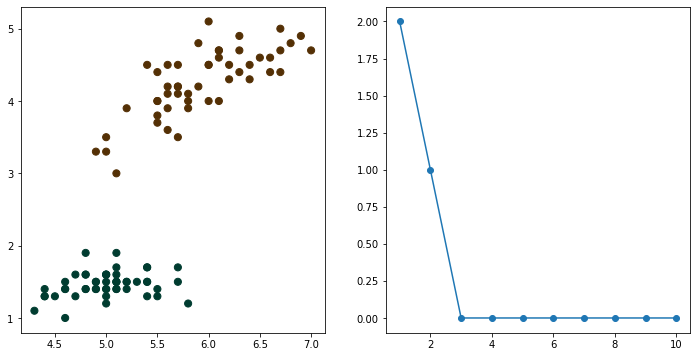

In [4]:
iris = load_iris()
X = iris.data
y = iris.target

## extruct for trial
y = np.where(y.copy()[0:100]==0, 1, -1)
X = X.copy()[0:100, [0, 2]]

# plot it
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X[:, 0], X[:, 1], s=50, c=y, cmap='BrBG')

# try it
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

# show the result
ax[1].plot(range(1, len(ppn.errors_)+1), ppn.errors_, marker='o')

plt.show();

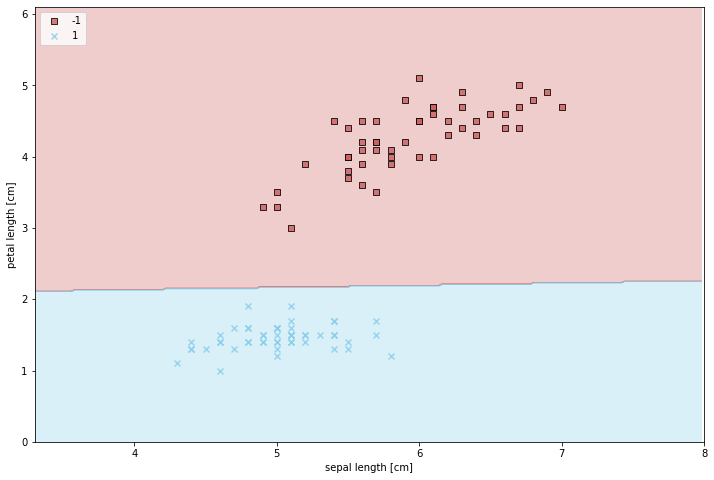

In [5]:
#plot decision regions & boundry
fig = plt.figure(figsize=(12, 8))
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show();

## ADALINE

In [0]:
class AdalineGD(Perceptron):
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1]+1)
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output

            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            cost = (errors**2).sum()/2.0
            self.cost_.append(cost)
        return self

    def activation(self, X):
        return X

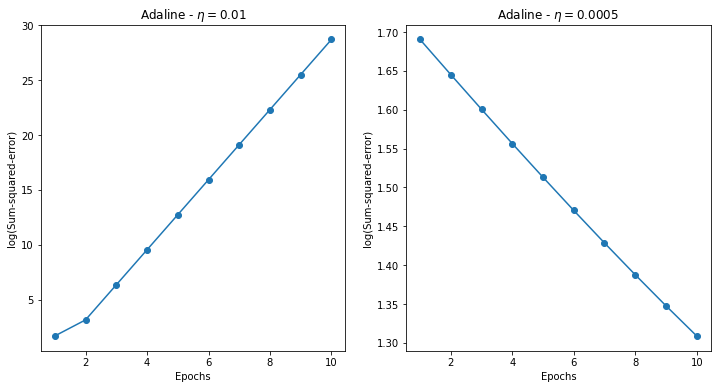

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ada2 = AdalineGD(n_iter=10, eta=0.0005).fit(X, y)

ax[0].plot(range(1, len(ada1.cost_)+1), np.log10(ada1.cost_), marker='o')
ax[0].set(xlabel='Epochs', ylabel='log(Sum-squared-error)', title='Adaline - $\eta=0.01$')

ax[1].plot(range(1, len(ada2.cost_)+1), np.log10(ada2.cost_), marker='o')
ax[1].set(xlabel='Epochs', ylabel='log(Sum-squared-error)', title='Adaline - $\eta=0.0005$')
plt.show();

## Standalize features and go

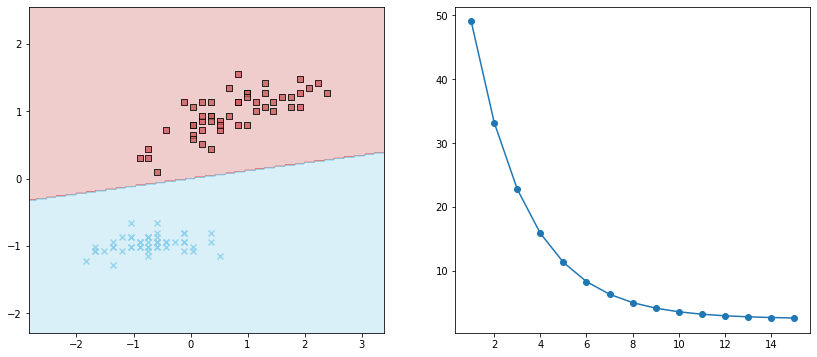

In [8]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_std = std.fit_transform(X)

ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)
# See the res
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2)

# see a boundary
ax1 = fig.add_subplot(gs[:, 0])
plot_decision_regions(X_std, y, classifier=ada)

# see errors
ax2 = fig.add_subplot(gs[:, 1])
ax2.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.show();

## Stochastic gradient descent
Batch gradient descent 
$$
    \Delta w = \eta \sum_i^N \left(y^{(i)} - \phi(z^{(i)}\right)x^{(i)}
$$

Stochastic (online) gradient descent
$$
    \eta\left(y^{(i)}-\phi(z^{(i)})\right)x^{(i)}
$$

In [0]:
# scratch it
class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.w_initialized = False


    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            if self.shuffle:
                self._shuffle(X, y)
            
            cost = []

            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    

    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m+1)
        self.w_initialized = True


    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = target - output
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error

        cost = 0.5 * error **2
        return cost


    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    

    def activation(self, X):
        return X

    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X))>=0.0, 1, -1)

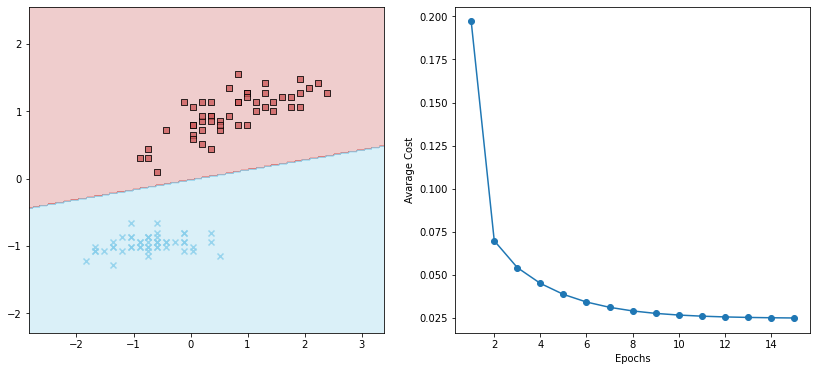

In [10]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=10)
ada.fit(X_std, y)


fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[:, 0])
plot_decision_regions(X_std,  y, ada)

ax2 = fig.add_subplot(gs[:, 1])
ax2.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
ax2.set(xlabel='Epochs', ylabel='Avarage Cost')
plt.show();